In [1]:
import torch, torchvision
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat

import numpy as np

from PIL import Image

import kornia

from apply_flow import apply_flow

device='cuda'

H, W = 224, 224
BATCH_SIZE = 1

img = Image.open("./img.png").resize([W, H]) 
img_tensor = torchvision.transforms.ToTensor()(img)
img_batch = repeat(img_tensor, 'h w c -> b h w c', b=BATCH_SIZE)
# img_batch = torch.rand(1, 3, 224, 224) * 0.1 + 0.5


flow_batch = torch.randn((BATCH_SIZE, H, W, 2), device=device)
flow_batch.requires_grad = True





img_batch = img_batch.to(device);



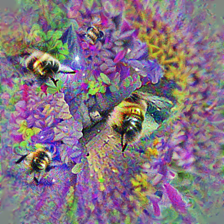

In [2]:
img

In [3]:
net = torchvision.models.resnet50(pretrained=True).cuda()

with torch.no_grad():
    scores = net(img_batch)
    img_class = scores.argmax(dim=-1)

In [4]:
img_class

tensor([463], device='cuda:0')

In [5]:
import tqdm


optimizer = torch.optim.Adam([flow_batch], lr=0.1)
for n in tqdm.tqdm(range(250)):  
    applied_flow_batch = torch.tanh(flow_batch) * 0.1
    flowed_img_batch = apply_flow(img_batch, applied_flow_batch)
    out = net(flowed_img_batch)
    target = -out[:, 655].mean()
    
    optimizer.zero_grad()
    target.backward()
    optimizer.step()


100%|██████████| 250/250 [00:09<00:00, 25.57it/s]


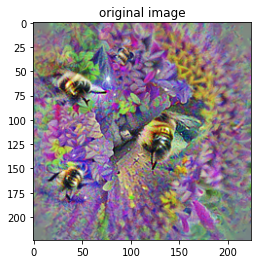

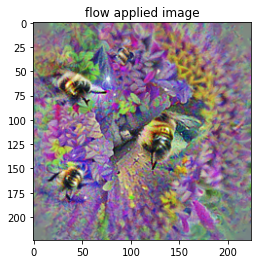

tensor([655], device='cuda:0')


In [6]:
plt.imshow(kornia.tensor_to_image(img_batch[0])); plt.title('original image'); plt.show()

plt.imshow(kornia.tensor_to_image(flowed_img_batch[0])); plt.title('flow applied image'); plt.show()

print(out.argmax(dim=-1))